In [58]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from grid import Grid

from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import event_times as iet

import obspy.signal.trigger as trigger

def pad_zeros(a, num, num2=None):
    """
    Pad num zeros at both sides of array a
    """
    if num2 is None:
        num2 = num
    hstack = [np.zeros(num, dtype=a.dtype), a, np.zeros(num2, dtype=a.dtype)]
    return np.hstack(hstack)

def detect_event_on_all_hydrophones(id):
    event = {}
    event['meta'] = iet.df.iloc[id]
    
    for h in ['h3', 'h4', 'h5', 'h6']:

        # data processing
        tr = iet.get_event_window(event['meta']['event_times (abs)'], hydrophone=h)

        # hann window taper
        tr.taper(type='hann', max_percentage=0.5)

        # aic detector initial hydrophone
        aic = trigger.aic_simple(tr.data)

        # ltasta other hydrophones
        starttime = 0 if h==event['meta'].hphone_idx else aic.argmin()
        # print(starttime)
        ltasta_a = tr.data.copy()
        ltasta_a[:starttime] = np.random.normal(0, scale=1e-2, size=starttime)
        ltasta = trigger.classic_sta_lta_py(a=ltasta_a, nsta=10, nlta=351//4)

        # data storage
        event[h] = {
            'data':tr.copy()
            ,'aic':aic
            ,'starttime':starttime
            ,'ltasta_data':ltasta_a
            ,'ltasta':ltasta
        }
    return event

In [59]:
iet.df[::4]

,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times,p_arrival_hphone_idx
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00,2019-05-21 07:38:10.186000+00:00
4,4,18037.318222,2019-05-21T07:38:14.405000Z,h3,1,2019-05-21 07:38:14.405000+00:00,2019-05-21 07:38:14.592000+00:00
8,8,18037.318263,2019-05-21T07:38:17.915000Z,h3,1,2019-05-21 07:38:17.915000+00:00,2019-05-21 07:38:17.884000+00:00
12,12,18037.318382,2019-05-21T07:38:28.204000Z,h3,1,2019-05-21 07:38:28.204000+00:00,2019-05-21 07:38:28.176000+00:00
16,16,18037.318564,2019-05-21T07:38:43.922000Z,h3,1,2019-05-21 07:38:43.922000+00:00,2019-05-21 07:38:44.100000+00:00
...,...,...,...,...,...,...,...
1956,286,18037.359489,2019-05-21T08:37:39.874000Z,h6,1,2019-05-21 08:37:39.874000+00:00,2019-05-21 08:37:39.854000+00:00
1960,290,18037.359508,2019-05-21T08:37:41.452000Z,h6,1,2019-05-21 08:37:41.452000+00:00,2019-05-21 08:37:41.428000+00:00
1964,294,18037.359525,2019-05-21T08:37:42.998000Z,h6,1,2019-05-21 08:37:42.998000+00:00,2019-05-21 08:37:42.960000+00:00
1968,298,18037.359551,2019-05-21T08:37:45.193000Z,h6,1,2019-05-21 08:37:45.193000+00:00,2019-05-21 08:37:45.159000+00:00


In [60]:
# event['meta'].event_times

In [107]:
event = detect_event_on_all_hydrophones(id=750)
event_time = pd.to_datetime(event['meta'].p_arrival_hphone_idx)
true_arrivals = [0, 0]
good_picks = [0, 0, 1, 1, 1, 1]
event_times = []
for h in ['h6', 'h5', 'h4', 'h3']:
    e = event[h]
    t = e['data'].times()
    if h == event['meta'].hphone_idx:
        true_arrivals.append(t[e['aic'].argmin()])
    else:
        true_arrivals.append(t[e['ltasta'].argmax()])

# print(true_arrivals)

for t in true_arrivals:
    et = event_time - event_time.floor('H') + pd.Timedelta(t*1e9)
    event_times.append(et.seconds + et.microseconds*1e-6)
# print(event_times)

event = {'good_picks':good_picks, 'event_times':event_times}

radius_depth = []
rms_mins = []
vps = np.arange(1000, 2000, 10)
for vp in vps:
    g = Grid(radius=50, gridscale=1, velocity_model=vp, depth=400)
    g.calc_travel_times(event=event, method='serial', centered=True)
    radius_depth.append(g.calc_location())
    print(g.calc_location())
    rms_mins.append(g.rms_grid[:, g.radius, :].min())
    print(g.rms_grid[:, g.radius, :].min())



using provided velocity model.
rms_grid calculated.
(-50, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-50, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-48, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-47, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-45, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-44, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-42, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-40, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-39, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-37, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-36, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-34, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-32, -290)
0.0
using provided velocity model.
rms_grid calculated.
(-32, -291)
0.0
using provided velocity model.
rms_grid calculat

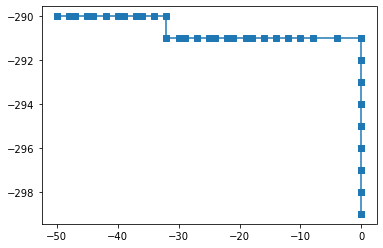

In [108]:
rd = np.array(radius_depth)

fig, ax = plt.subplots()
ax.plot(rd[:,0], rd[:,1], marker='s')

Text(0.5, 0, 'vp')

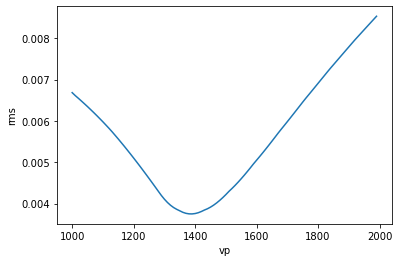

In [111]:
fig, ax = plt.subplots()

ax.plot(vps, rms_mins)
ax.set_ylabel('rms')
ax.set_xlabel('vp')

using provided velocity model.


/home/john/research/borehole_proj2/grid.py:209: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  t0 = np.linalg.lstsq(t0_top, t0_bottom)[0]


rms_grid calculated.
(0, -292)
0.0037598510065966597


(0, -292)

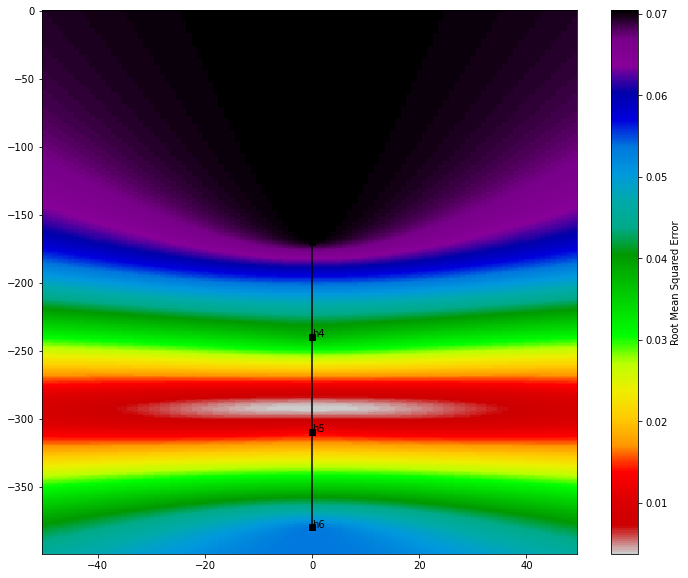

In [112]:
g = Grid(radius=50, gridscale=1, velocity_model=1400, depth=400)
g.calc_travel_times(event=event, method='serial', centered=True)
radius_depth.append(g.calc_location())
print(g.calc_location())
rms_mins.append(g.rms_grid[:, g.radius, :].min())
print(g.rms_grid[:, g.radius, :].min())

g.plot_rms_grid()
g.calc_location()

In [113]:
event

{'good_picks': [0, 0, 1, 1, 1, 1],
 'event_times': [318.019, 318.019, 318.18, 318.137, 318.105, 318.163]}

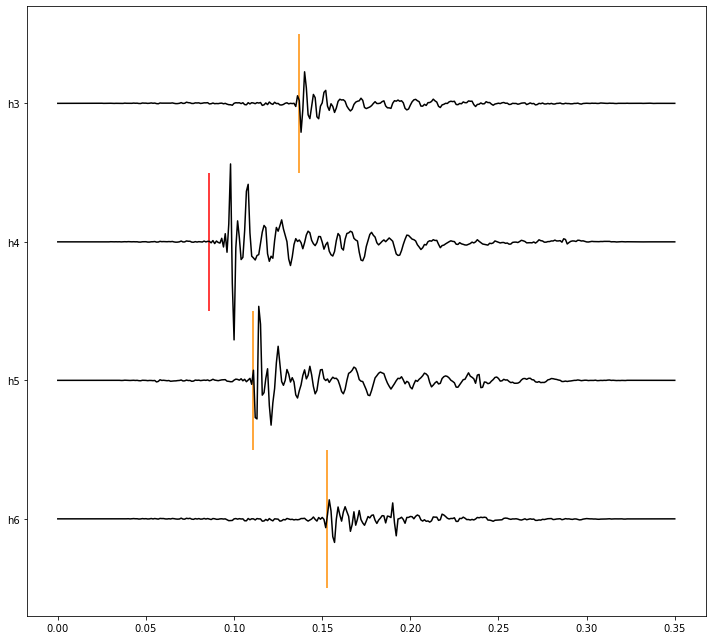

In [115]:
event = detect_event_on_all_hydrophones(id=750)
hydrophone_ids = ['h6', 'h5', 'h4', 'h3']

fig, ax = plt.subplots(figsize=(10,9))

for n, h in enumerate(hydrophone_ids):
    e = event[h]
    t = e['data'].times()
    ax.plot(t, e['data'].data+n, color='black')

    if h == event['meta'].hphone_idx:
        ax.vlines(t[e['aic'].argmin()], ymin=-0.5+n, ymax=0.5+n, color='red')
    else:
        ltasta_diff = np.diff(e['ltasta'])
        ax.vlines(t[ltasta_diff.argmax()], ymin=-0.5+n, ymax=0.5+n, color='darkorange')

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(hydrophone_ids)
fig.tight_layout()

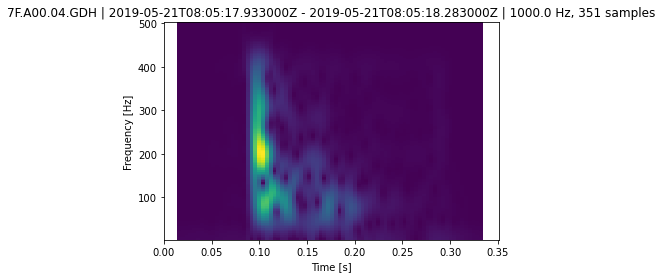

In [120]:
event['h4']['data'].spectrogram()

In [67]:
vps = np.arange(500, 8000, 100)

for vp in vps:
    g = Grid(radius=50, gridscale=1, velocity_model=vp, depth=400)
    
    for id in iet.df[::4]:
        true_arrivals = [0, 0]
        good_picks = [0, 0, 1, 1, 1, 1]
        event_times = []
        
        event = detect_event_on_all_hydrophones(id=750)
        event_time = pd.to_datetime(event['meta'].p_arrival_hphone_idx)
        
        for h in ['h6', 'h5', 'h4', 'h3']:
            e = event[h]
            t = e['data'].times()
            if h == event['meta'].hphone_idx:
                true_arrivals.append(t[e['aic'].argmin()])
            else:
                true_arrivals.append(t[e['ltasta'].argmax()])
                
        # print(true_arrivals)
        
        for t in true_arrivals:
            et = event_time - event_time.floor('H') + pd.Timedelta(t*1e9)
            event_times.append(et.seconds + et.microseconds*1e-6)
        # print(event_times)
        
        event = {'good_picks':good_picks, 'event_times':event_times}
        g.calc_travel_times(event=event, method='serial', centered=True)
        

using provided velocity model.
[318.019, 318.019, 318.178, 318.135, 318.105, 318.163]


In [62]:
event['h3'].keys()

dict_keys(['data', 'aic', 'starttime', 'ltasta_data', 'ltasta'])

In [63]:
event

{'meta': index                                                452
 event_times (mpl)                           18037.337014
 event_times (abs)            2019-05-21T08:05:18.033000Z
 hphone_idx                                            h4
 ones                                                   1
 event_times             2019-05-21 08:05:18.033000+00:00
 p_arrival_hphone_idx    2019-05-21 08:05:18.019000+00:00
 Name: 750, dtype: object,
 'h3': {'data': 7F.A00.03.GDH | 2019-05-21T08:05:17.933000Z - 2019-05-21T08:05:18.283000Z | 1000.0 Hz, 351 samples,
  'aic': array([-2565.34645929, -2617.3672368 , -2633.05504302, -2639.7353331 ,
         -2656.61693941, -2668.62371186, -2684.70084589, -2701.63849979,
         -2697.35238701, -2705.7173797 , -2705.32539312, -2718.35300304,
         -2729.82731557, -2737.2132086 , -2749.81088151, -2748.78886928,
         -2760.65448597, -2770.76310686, -2767.90838069, -2769.49947058,
         -2766.42639805, -2776.0473113 , -2785.15637835, -2784.36426   

In [7]:
iet.df.iloc[0::4]

,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times,p_arrival_hphone_idx
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00,2019-05-21 07:38:10.186000+00:00
4,4,18037.318222,2019-05-21T07:38:14.405000Z,h3,1,2019-05-21 07:38:14.405000+00:00,2019-05-21 07:38:14.592000+00:00
8,8,18037.318263,2019-05-21T07:38:17.915000Z,h3,1,2019-05-21 07:38:17.915000+00:00,2019-05-21 07:38:17.884000+00:00
12,12,18037.318382,2019-05-21T07:38:28.204000Z,h3,1,2019-05-21 07:38:28.204000+00:00,2019-05-21 07:38:28.176000+00:00
16,16,18037.318564,2019-05-21T07:38:43.922000Z,h3,1,2019-05-21 07:38:43.922000+00:00,2019-05-21 07:38:44.100000+00:00
...,...,...,...,...,...,...,...
1956,286,18037.359489,2019-05-21T08:37:39.874000Z,h6,1,2019-05-21 08:37:39.874000+00:00,2019-05-21 08:37:39.854000+00:00
1960,290,18037.359508,2019-05-21T08:37:41.452000Z,h6,1,2019-05-21 08:37:41.452000+00:00,2019-05-21 08:37:41.428000+00:00
1964,294,18037.359525,2019-05-21T08:37:42.998000Z,h6,1,2019-05-21 08:37:42.998000+00:00,2019-05-21 08:37:42.960000+00:00
1968,298,18037.359551,2019-05-21T08:37:45.193000Z,h6,1,2019-05-21 08:37:45.193000+00:00,2019-05-21 08:37:45.159000+00:00


In [10]:
event

index                                                 75
event_times (mpl)                           18037.319457
event_times (abs)            2019-05-21T07:40:01.120000Z
hphone_idx                                            h3
ones                                                   1
event_times             2019-05-21 07:40:01.120000+00:00
p_arrival_hphone_idx    2019-05-21 07:40:01.098000+00:00
Name: 75, dtype: object

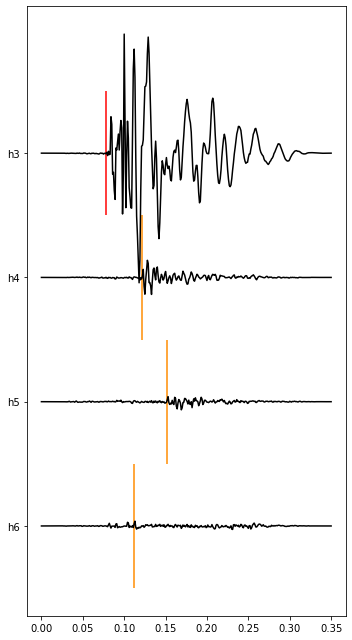

In [3]:
event = detect_event_on_all_hydrophones(id=75)
hydrophone_ids = ['h6', 'h5', 'h4', 'h3']

fig, ax = plt.subplots(figsize=(5,9))

for n, h in enumerate(hydrophone_ids):
    e = event[h]
    t = e['data'].times()
    ax.plot(t, e['data'].data+n, color='black')

    if h == event['meta'].hphone_idx:
        ax.vlines(t[e['aic'].argmin()], ymin=-0.5+n, ymax=0.5+n, color='red')
    else:
        ltasta_diff = np.diff(e['ltasta'])
        ax.vlines(t[ltasta_diff.argmax()], ymin=-0.5+n, ymax=0.5+n, color='darkorange')

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(hydrophone_ids)
fig.tight_layout()